# NLP: Using Pre-Trained Word Embeddings

In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Defining a results visualization function
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

## Pre-Trained Networks and Word Embeddings


In [3]:
# More specific imports
import nltk
from nltk.corpus import stopwords

from gensim.models import word2vec

Data is: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [4]:
df = pd.read_csv('data/IMDB_Reviews.csv')

In [5]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
# Our target value
df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

### Pre-Split Preprocessing

Doing some initial preprocessing that can be done before the train/test split

In [8]:
# Let's check out an example review...
index_num = 15903 # Defining the index number of the review to explore

df['review'].iloc[index_num]

'THIS IS NOT A CHILDREN\'S MOVIE!!!<br /><br />This movie is like a "bad acid trip" for kids under the age of 5. For a month my 4 year old from time-to-time would ask me "Why was that rabbit bleeding from its mouth" or "Why did the bulldozer bury all the rabbits?". (And that wasn\'t the worst of it). We stopped it about a 1/2 hour in but the damage had been done. Intensely morbid, oppressive, violent. Fortunately he\'s finally forgotten about the whole wretched thing. Whomever decided this movie should be marketed to children should be brought up on charges. ... (Go ahead censure me, my conscience is clear.).'

We have some HTML tags inside these texts... will want to remove them. But how?

Enter: Regular Expressions (regex).

Testing: https://regexr.com/

In [9]:
# Find the pattern to remove html tags
import re

html_tag_pattern = re.compile(r'<[^>]*>')

test = html_tag_pattern.sub('', df['review'].iloc[index_num])

In [10]:
test

'THIS IS NOT A CHILDREN\'S MOVIE!!!This movie is like a "bad acid trip" for kids under the age of 5. For a month my 4 year old from time-to-time would ask me "Why was that rabbit bleeding from its mouth" or "Why did the bulldozer bury all the rabbits?". (And that wasn\'t the worst of it). We stopped it about a 1/2 hour in but the damage had been done. Intensely morbid, oppressive, violent. Fortunately he\'s finally forgotten about the whole wretched thing. Whomever decided this movie should be marketed to children should be brought up on charges. ... (Go ahead censure me, my conscience is clear.).'

In [11]:
# Apply our pattern to the dataset
df['review'] = df['review'].map(lambda x: re.sub(r'<[^>]*>', '', x))

# Same as
# df['review'] = df['review'].map(lambda x: html_tag_pattern.sub('', x))

In [12]:
# Sanity check
df['review'].iloc[index_num]

'THIS IS NOT A CHILDREN\'S MOVIE!!!This movie is like a "bad acid trip" for kids under the age of 5. For a month my 4 year old from time-to-time would ask me "Why was that rabbit bleeding from its mouth" or "Why did the bulldozer bury all the rabbits?". (And that wasn\'t the worst of it). We stopped it about a 1/2 hour in but the damage had been done. Intensely morbid, oppressive, violent. Fortunately he\'s finally forgotten about the whole wretched thing. Whomever decided this movie should be marketed to children should be brought up on charges. ... (Go ahead censure me, my conscience is clear.).'

Let's also remove stopwords

In [13]:
stop_words = stopwords.words('english')

In [14]:
# Neat bit of code!
df['review'] = df['review'].apply(lambda x: ' '.join(
    [word for word in x.split() if word.lower() not in (stop_words)]))

Can also pre-process our target variable

In [15]:
# Create a target map
target_map = {'positive': 1,
              'negative': 0}

In [16]:
# Map it
df['sentiment'] = df['sentiment'].map(target_map)

In [17]:
# Sanity check
df.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,1
1,wonderful little production. filming technique...,1
2,thought wonderful way spend time hot summer we...,1
3,Basically there's family little boy (Jake) thi...,0
4,"Petter Mattei's ""Love Time Money"" visually stu...",1


### Split, and then Post-Split Processing
Now let's perform a train/test split:

In [18]:
# Define our X and y
X = df['review']
y = df['sentiment']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
X_train.shape

(37500,)

In [20]:
# Need to find that same review now that the index is shuffled
train_index_num = X_train.index.get_loc(15903)
X_train.iloc[train_index_num]

'CHILDREN\'S MOVIE!!!This movie like "bad acid trip" kids age 5. month 4 year old time-to-time would ask "Why rabbit bleeding mouth" "Why bulldozer bury rabbits?". (And worst it). stopped 1/2 hour damage done. Intensely morbid, oppressive, violent. Fortunately he\'s finally forgotten whole wretched thing. Whomever decided movie marketed children brought charges. ... (Go ahead censure me, conscience clear.).'

### Vanilla Text Classification... What Would We Do?

Aka what would this look like without a NN?

In [21]:
# Let's use a TF-IDF vectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
# What parameters should we set? What steps have we already done, what do we still need to do?
# Already removed stopwords!
vectorizer = TfidfVectorizer(
    max_df=.95,  # removes words that appear in more than 95% of docs
    min_df=2 # removes words that appear 2 or fewer times
)  

In [23]:
vectorizer.fit(X_train)

X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

#### Explore Our Vectorized Text

In [24]:
# Let's look at that second example again
X_train.iloc[train_index_num]

'CHILDREN\'S MOVIE!!!This movie like "bad acid trip" kids age 5. month 4 year old time-to-time would ask "Why rabbit bleeding mouth" "Why bulldozer bury rabbits?". (And worst it). stopped 1/2 hour damage done. Intensely morbid, oppressive, violent. Fortunately he\'s finally forgotten whole wretched thing. Whomever decided movie marketed children brought charges. ... (Go ahead censure me, conscience clear.).'

In [25]:
train_index_num

22171

In [26]:
X_train.loc[X_train.str.contains('CHILDREN\'S MOVIE!!!')]

15903    CHILDREN'S MOVIE!!!This movie like "bad acid t...
Name: review, dtype: object

In [27]:
# Creating a df of tf-idf values, where each column is a word in the vocabulary
tfidf_train_df = pd.DataFrame(X_train_vec.toarray(), 
                              columns=vectorizer.get_feature_names(), 
                              index=X_train.index)

In [28]:
# Grabbing that row once it's been vectorized
test_doc = tfidf_train_df.iloc[train_index_num]

test_doc[test_doc > 0].sort_values(ascending=False).head(15) # Showing values > 0

censure       0.248884
bulldozer     0.228991
why           0.217933
whomever      0.202968
children      0.202369
rabbits       0.197874
oppressive    0.188972
bleeding      0.186441
bury          0.185497
charges       0.183285
marketed      0.182048
intensely     0.174200
morbid        0.174200
wretched      0.170670
conscience    0.168263
Name: 15903, dtype: float64

What does this tell you about the word "censure" in the this document?

- 


In [29]:
# Now let's model
from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

In [30]:
classifier.fit(X_train_vec, y_train)

classifier.score(X_test_vec, y_test)

0.86592

Evaluate:

- 


## Moving to NN-Based Text Classification!

#### Different Pre-Processing Steps!

Let's walk through these steps first, then discuss why we didn't just use vectorized text.

Going to use keras's tokenizer: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [31]:
# Find our longest review - will need for padding later
max_length = max([len(s.split()) for s in X_train])
max_length

1452

In [32]:
# Now to tokenize
# Recommend checking out their default values - they're removing punctuation for us!
tokenizer = keras.preprocessing.text.Tokenizer()

tokenizer.fit_on_texts(X_train)

X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

In [33]:
# What is this doing? 
#Let's look at the first 10 key-value pairs in the word_index dict

list(tokenizer.word_index.items())[:10]

[('movie', 1),
 ('film', 2),
 ('one', 3),
 ('like', 4),
 ('good', 5),
 ('it', 6),
 ('the', 7),
 ('time', 8),
 ('even', 9),
 ('would', 10)]

In [34]:
# Same example, after processing
print(X_train_token[train_index_num])

[2549, 1, 46, 1, 4, 16, 4589, 1171, 264, 502, 360, 3397, 365, 216, 67, 8, 283, 8, 10, 889, 611, 3884, 9414, 1544, 611, 27791, 8948, 11048, 54, 152, 6, 2309, 218, 138, 440, 3939, 128, 6426, 6367, 9737, 1073, 3051, 147, 328, 1441, 123, 5705, 61, 14315, 791, 1, 8056, 387, 736, 8186, 56, 1390, 43595, 133, 5075, 674]


In [35]:
# Grab the corpus size
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

110202


In [36]:
# Now, let's pad so each review is the same length as our longest review
# Basically, adding zeros at the end

X_train_processed = keras.preprocessing.sequence.pad_sequences(
    X_train_token, maxlen=max_length, padding='post')
X_test_processed = keras.preprocessing.sequence.pad_sequences(
    X_test_token, maxlen=max_length, padding='post')

In [37]:
print(X_train_processed[2])

[131 152   1 ...   0   0   0]


#### Why Couldn't We Just Use TF-IDF?

In [38]:
# Look at the vectorized text
tfidf_train_df.head()

,00,000,001,007,0083,00am,00pm,00s,01,02,...,zázvorková,æon,élan,émigré,émigrés,était,état,être,óli,über
27434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
# Look at the preprocessed text from keras
X_train_processed

array([[ 768, 4784,  548, ...,    0,    0,    0],
       [ 148,    1,  404, ...,    0,    0,    0],
       [ 131,  152,    1, ...,    0,    0,    0],
       ...,
       [ 719,    3,  297, ...,    0,    0,    0],
       [ 266,   85,  779, ...,    0,    0,    0],
       [ 451,    1,  165, ...,    0,    0,    0]])

What is the difference? Specifically, what are the columns representing in each of these? What are the numbers?

- 


## Using Pre-Trained Word Embeddings in NNs for NLP Tasks

For the most part, following this example: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

Also relevant: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

### GloVe (Global Vectors for Word Representation)

The link to download the GloVe files: https://nlp.stanford.edu/projects/glove/

> **You will need to download the GloVe embeddings directly, since these files are all too big for github!**

The below function and code comes from: https://realpython.com/python-keras-text-classification/#using-pretrained-word-embeddings

In [43]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [44]:
embedding_dim = 50
embedding_matrix = create_embedding_matrix('glove/glove.6B.50d.txt',
                                           tokenizer.word_index, 
                                           embedding_dim)

In [47]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.30824   ,  0.17223001, -0.23339   , ..., -0.98176998,
        -0.32146999,  0.99822998],
       [ 0.06912   ,  0.22159   , -0.66613001, ..., -0.93550998,
        -0.20942999,  0.67333001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.11450005, -0.36491001,  0.27649   , ..., -0.29796001,
         0.60066998, -0.73312002],
       [ 0.039808  ,  0.70003003,  0.85829997, ..., -1.84660006,
        -0.53987998,  0.30724001]])

How is this different from previous preprocessing steps?

- 


In [48]:
# Time to model!
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=False)) # Note - not retraining the embedding layer
model.add(layers.Flatten()) # flattening these layers down before connecting to dense layer
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1452, 50)          5510100   
_________________________________________________________________
flatten (Flatten)            (None, 72600)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 72601     
Total params: 5,582,701
Trainable params: 72,601
Non-trainable params: 5,510,100
_________________________________________________________________


In [49]:
history = model.fit(X_train_processed, y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_test_processed, y_test))

Epoch 1/10
375/375 [==============================] - 10s 26ms/step - loss: 0.5814 - accuracy: 0.7049 - val_loss: 0.5604 - val_accuracy: 0.7262
Epoch 2/10
375/375 [==============================] - 9s 25ms/step - loss: 0.4729 - accuracy: 0.7778 - val_loss: 0.5888 - val_accuracy: 0.7245
Epoch 3/10
375/375 [==============================] - 10s 26ms/step - loss: 0.4399 - accuracy: 0.7951 - val_loss: 0.6067 - val_accuracy: 0.7195
Epoch 4/10
375/375 [==============================] - 10s 27ms/step - loss: 0.4216 - accuracy: 0.8065 - val_loss: 0.6326 - val_accuracy: 0.7154
Epoch 5/10
375/375 [==============================] - 10s 27ms/step - loss: 0.4096 - accuracy: 0.8119 - val_loss: 0.6428 - val_accuracy: 0.7179
Epoch 6/10
375/375 [==============================] - 10s 27ms/step - loss: 0.3986 - accuracy: 0.8177 - val_loss: 0.6582 - val_accuracy: 0.7155
Epoch 7/10
375/375 [==============================] - 10s 27ms/step - loss: 0.3906 - accuracy: 0.8222 - val_loss: 0.7041 - val_accuracy: 

Test loss: 0.7304790019989014
Test accuracy: 0.7054399847984314


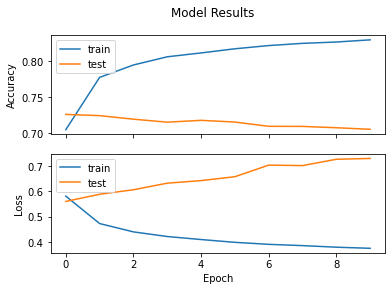

In [50]:
score = model.evaluate(X_test_processed, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

Evaluate:

- 


### Treat Embeddings as Starting Weights, but Allow Training:

In [51]:
# Time to model!
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True)) # Now it can retrain the embedding layer
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1452, 50)          5510100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 72600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 72601     
Total params: 5,582,701
Trainable params: 5,582,701
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = model.fit(X_train_processed, y_train,
                    epochs=10,
                    batch_size=100,
                    validation_data=(X_test_processed, y_test))
# Takes about... 3 minutes?

Epoch 1/10
375/375 [==============================] - 38s 100ms/step - loss: 0.5114 - accuracy: 0.7553 - val_loss: 0.4243 - val_accuracy: 0.8140
Epoch 2/10
375/375 [==============================] - 37s 99ms/step - loss: 0.2674 - accuracy: 0.8938 - val_loss: 0.3476 - val_accuracy: 0.8574
Epoch 3/10
375/375 [==============================] - 37s 99ms/step - loss: 0.1625 - accuracy: 0.9437 - val_loss: 0.3351 - val_accuracy: 0.8689
Epoch 4/10
375/375 [==============================] - 37s 100ms/step - loss: 0.1022 - accuracy: 0.9708 - val_loss: 0.3466 - val_accuracy: 0.8703
Epoch 5/10
375/375 [==============================] - 37s 99ms/step - loss: 0.0639 - accuracy: 0.9855 - val_loss: 0.3597 - val_accuracy: 0.8696
Epoch 6/10
375/375 [==============================] - 37s 98ms/step - loss: 0.0399 - accuracy: 0.9935 - val_loss: 0.3750 - val_accuracy: 0.8699
Epoch 7/10
375/375 [==============================] - 37s 98ms/step - loss: 0.0250 - accuracy: 0.9970 - val_loss: 0.3944 - val_accurac

Test loss: 0.44764000177383423
Test accuracy: 0.8712000250816345


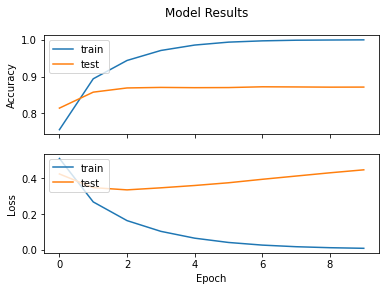

In [53]:
score = model.evaluate(X_test_processed, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

Evalutate:

- 


### Early Stopping

Patience: how many epochs that model can keep running without improvement before the training is stopped

Reference: https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [54]:
# Implement early stopping
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [55]:
# Combine with a model saving feature, so it saves as it improves
from keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [56]:
# Same model as just before this
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1452, 50)          5510100   
_________________________________________________________________
flatten_1 (Flatten)          (None, 72600)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 72601     
Total params: 5,582,701
Trainable params: 5,582,701
Non-trainable params: 0
_________________________________________________________________


In [57]:
# Just adding more epochs
history = model.fit(X_train_processed, y_train,
                    epochs=100,
                    batch_size=100,
                    validation_data=(X_test_processed, y_test),
                    callbacks=[es, mc])

# This takes... a while

Epoch 1/100
375/375 [==============================] - ETA: 0s - loss: 0.0049 - accuracy: 0.9999
Epoch 00001: val_accuracy improved from -inf to 0.87152, saving model to best_model.h5
375/375 [==============================] - 37s 99ms/step - loss: 0.0049 - accuracy: 0.9999 - val_loss: 0.4629 - val_accuracy: 0.8715
Epoch 2/100
375/375 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9999
Epoch 00002: val_accuracy did not improve from 0.87152
375/375 [==============================] - 37s 98ms/step - loss: 0.0035 - accuracy: 0.9999 - val_loss: 0.4779 - val_accuracy: 0.8715
Epoch 3/100
375/375 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 1.0000
Epoch 00003: val_accuracy did not improve from 0.87152
375/375 [==============================] - 37s 99ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.4922 - val_accuracy: 0.8714
Epoch 00003: early stopping


### LSTM

Note: there might still be a bug in tensorflow related to the newest numpy version, if you have numpy version 1.20+ this might not work.

https://github.com/tensorflow/models/issues/9706

In [58]:
np.__version__

'1.19.2'

In [59]:
model = keras.models.Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim,
                           weights=[embedding_matrix],
                           input_length=max_length,
                           trainable=True))
# Replacing our Flattening layer with an LSTM
# Adding some dropout to prevent overfitting - note the two ways to do so
model.add(layers.LSTM(embedding_dim, 
                      dropout=0.2,
                      return_sequences=True))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1452, 50)          5510100   
_________________________________________________________________
lstm (LSTM)                  (None, 1452, 50)          20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1452, 1)           51        
Total params: 5,530,351
Trainable params: 5,530,351
Non-trainable params: 0
_________________________________________________________________


We could do this all here... or we could move over to Kaggle and run this with GPUs!

### Saving your model

In [60]:
model.save('model.h5')
model.save_weights('model_weights.h5')

In [61]:
from keras.models import load_model

my_model = load_model('model.h5')
my_model.load_weights('model_weights.h5')

In [63]:
my_model.evaluate(X_test_processed, y_test.values)

391/391 [==============================] - 90s 230ms/step - loss: 0.6938 - accuracy: 0.4929


[0.6938403248786926, 0.492878794670105]

## Additional Resources

- Sklearn's [Working with Text Data Tutorial](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html)

What else can we do with natural language data beyond text classification? 

- [This blog post](https://blog.aureusanalytics.com/blog/5-natural-language-processing-techniques-for-extracting-information) by Aureus Analytics provides an overview of other machine learning techniques used to extract meaning from text: Named Entity Recognition, Sentiment Analysis, Text Summarization, Aspect Mining and Topic Modeling

### Neural Network Vectorizer Resources:

Want another way to embed words for machine learning? Check out Word2Vec - a way of vectorizing text that tries to capture the relationships between words. See the image below, from [this paper](https://arxiv.org/pdf/1310.4546.pdf) from Google developers, that introduced a Skip-gram neural network model that's been utilized by Word2Vec (which is a tool you can use to implement this model). You'll note that the distance between each country and it's capital city is about the same - that distance actually has meaning, and thus you can imagine that the difference between `cat` and `kitten` would be the same as the difference between `dog` and `puppy`. Et cetera!

![screenshot from a paper on the Skip-gram model from devleopers at Google, https://arxiv.org/pdf/1310.4546.pdf](images/Fig2-DsitributedRepresentationsOfWordsAndPhrasesAndTheirCompositionality.png)

- [Pathmind's A.I. Wiki - A Beginner's Guide to Word2Vec](https://wiki.pathmind.com/word2vec)
- [Chris McCormick's Word2Vec Tutorial](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
- [What is the difference between Word2Vec and GloVe?](https://machinelearninginterview.com/topics/natural-language-processing/what-is-the-difference-between-word2vec-and-glove/)